<a href="https://colab.research.google.com/github/ehager77/intro_to_ai/blob/master/intro_to_ai_hw4_ehager.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing the required packages

import os
import re

import pandas as pd
import numpy as np

import seaborn as sn
import gensim
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords 
import nltk
nltk.download('punkt')

from sklearn import feature_selection

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from itertools import compress
import collections

import string

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data = '/content/drive/My Drive/empatheticdialogues'

In [ ]:
# first step is to preprocess the data

# Importing the datasets
train = pd.read_csv(data+'/train.csv', error_bad_lines=False)
valid = pd.read_csv(data+ '/valid.csv', error_bad_lines=False)
test = pd.read_csv(data+'/test.csv', error_bad_lines=False)

In [ ]:
# 1
# select "utterance" and "context" as your X and y
# only select {'sad', 'jealous', 'joyful', 'terrified'} categories
# use pandas.loc function to do it!

df_train = train.loc[train.context.isin(['sad', 'jealous', 'joyful', 'terrified'])]
df_train = df_train[['context', 'utterance']]
df_train['utterance'] = df_train['utterance'].str.lower()
df_test = test.loc[test.context.isin(['sad', 'jealous', 'joyful', 'terrified'])]
df_test = df_test[['context', 'utterance']]
df_test['utterance'] = df_test['utterance'].str.lower()
df_train = df_train.rename(columns={"context":"y", "utterance":"text"})
df_test = df_test.rename(columns={"context":"y", "utterance":"text"})

In [ ]:
df_train

In [ ]:
# Visualizing makeup of training set
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
df_train["y"].reset_index().groupby("y").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [ ]:
# Visualizing makeup of test set
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
df_test["y"].reset_index().groupby("y").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [ ]:
# Getting the train labels; this will be used for SGD classifier
le = preprocessing.LabelEncoder()
train_labels_encoded = le.fit(df_train['y'])
test_labels_encoded = le.fit(df_test['y'])
df_train['y_enc'] = train_labels_encoded.transform(df_train['y'])
df_test['y_enc'] = test_labels_encoded.transform(df_test['y'])

In [ ]:
# note train and test labels are in train_labels_encoded and labels_encoded_test

# data preprocessing, remove punctuations from the sentence
# DO NOT REMOVE STOPWORDS here
# follow this article should be good to go 
# https://medium.com/@arunm8489/getting-started-with-natural-language-processing-6e593e349675
# https://machinelearningmastery.com/clean-text-machine-learning-python/

# Remove 'comma'
df_train['text'] = df_train['text'].str.replace('_comma_', '')
# Remove numeric characters using regex
df_train['text'] = df_train['text'].str.replace('\d+', '')

df_test['text'] = df_test['text'].str.replace('_comma_', '')
df_test['text'] = df_test['text'].str.replace('\d+', '')

# Remove punctuation 
df_train['text_cleaned'] = df_train['text'].str.replace('[{}]'.format(string.punctuation), '')
df_test['text_cleaned'] = df_test['text'].str.replace('[{}]'.format(string.punctuation), '')

In [ ]:
df_train

In [ ]:
## get target
y_train = df_train["y_enc"].values
y_test = df_test["y_enc"].values
print(type(y_train))

In [ ]:
### 2
## Converting the utterances into a sparse bag-of-words 
# Create the bag of words feature matrix

# Unigram BOW representation
unigram_vectorizer = CountVectorizer(ngram_range=(1, 1))
X_train_unigram = unigram_vectorizer.fit_transform(df_train['text_cleaned'].values)

# Get feature names
feature_names = unigram_vectorizer.get_feature_names()

# View BOW Matrix
pd.DataFrame(X_train_unigram.toarray(), columns=feature_names)

In [ ]:
### 3 
## The shortcomings with the previous representation are?
# Answer:  There may be many words that don't add any predictive power to the model. 

# so we should possibly remove stop words.
# Getting the list of stopwords and appending additional words to it
stopwords_list = list(set(stopwords.words('english')))

# remove the tokens in the stopwords list from utterance

df_train['text_cleaned'] = df_train['text_cleaned'].str.replace('[{}]'.format(stopwords_list), '')
df_test['text_cleaned'] =  df_test['text_cleaned'].str.replace('[{}]'.format(stopwords_list), '')

In [ ]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df_train['text_tokenized'] = df_train.text_cleaned.apply(lemmatize_text)
df_train['text_lemmatized'] = df_train.text_tokenized.apply(lambda x: " ".join(x))
df_test['text_tokenized'] = df_test.text_cleaned.apply(lemmatize_text)
df_test['text_lemmatized'] = df_test.text_tokenized.apply(lambda x: " ".join(x))
df_test

In [ ]:
# 4
## Tf-Idf (using trigrams instead of unigrams)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,3))
corpus = df_train["text_lemmatized"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import numpy as np

def train_and_show_scores(X: csr_matrix, y: np.array, title: str) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.75, stratify=y
    )
    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'{title}\nTrain score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}\n')

train_and_show_scores(X_train, y_train, 'Trigram Tf-Idf')

In [ ]:
# 5. Build an SGD Classifier

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Phase 1: loss, learning rate and initial learning rate

clf = SGDClassifier()

distributions = dict(
    loss=['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    learning_rate=['optimal', 'invscaling', 'adaptive'],
    eta0=uniform(loc=1e-7, scale=1e-2),
    penalty=['l1', 'l2', 'elasticnet'],
    alpha=uniform(loc=1e-6, scale=1e-4)
)

random_search_cv = RandomizedSearchCV(
    estimator=clf,
    param_distributions=distributions,
    cv=10,
    n_iter=50
)
random_search_cv.fit(X_train, y_train)
print(f'Best params: {random_search_cv.best_params_}')
print(f'Best score: {random_search_cv.best_score_}')

In [ ]:
sgd_classifier = random_search_cv.best_estimator_

In [ ]:
X_test = df_test['text_lemmatized']
X_test = vectorizer.transform(X_test)
predictions = sgd_classifier.predict(X_test)
score = sgd_classifier.score(X_test, y_test)
print('Accuracy on test set:', round(score,2))

In [ ]:
#Confusion Matrix
class_names = train_labels_encoded.classes_
y_true = y_test
y_pred = predictions
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=class_names, index=class_names)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,10))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size

In [ ]:
def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sn.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
plot_cm(y_true, y_pred)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
precision = precision_score(y_true, y_pred, average=None)
recall_sc = recall_score(y_true, y_pred, average=None)
f1_sc = f1_score(y_true, y_pred, average=None)
df = pd.DataFrame(data=precision, index=class_names, columns=['Precision Score'])
df['Recall Score'] = recall_sc
df['F1 Score'] = f1_sc
print(df)

In [183]:
## 6
# Using Word2Vec and Neural Net Multinomial Classifier
import gensim
import gensim.downloader as gensim_api

In [184]:
nlp = gensim_api.load("word2vec-google-news-300")

In [185]:
## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [186]:
## fit w2v
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=8, min_count=1, sg=1, iter=30)

In [187]:
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [188]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

In [189]:
i = 0

## list of text: ["I like this", ...]
len_txt = len(df_train["text_lemmatized"].iloc[i].split())
print("from: ", df_train["text_lemmatized"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", df_train["text_lemmatized"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[df_train["text_lemmatized"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  job interview always make me sweat bullet make me uncomfortable in general to be looked at under a microscope like that | len: 21
to:  [ 135  719   93   81   18 2443 2444   81   18 2069   17 1483    4   22
  632] | len: 15
check:  job  -- idx in vocabulary --> 135
vocabulary:  {'NaN': 1, 'i': 2, 'a': 3, 'to': 4, 'it': 5} ... (padding element, 0)


In [190]:
corpus_test = df_test["text_lemmatized"]

## create list of n-grams
lst_corpus_test = []
for string in corpus_test:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus_test.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus_test = list(bigrams_detector[lst_corpus_test])
lst_corpus_test = list(trigrams_detector[lst_corpus_test])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus_test)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")

In [191]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [192]:
word = "love"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 122 |idx
embeddings[idx]: (300,) |vector


In [193]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=15)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(4, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 15, 300)      2279700     input_4[0][0]                    
__________________________________________________________________________________________________
permute_3 (Permute)             (None, 300, 15)      0           embedding_3[0][0]                
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 300, 15)      240         permute_3[0][0]                  
_______________________________________________________________________________________

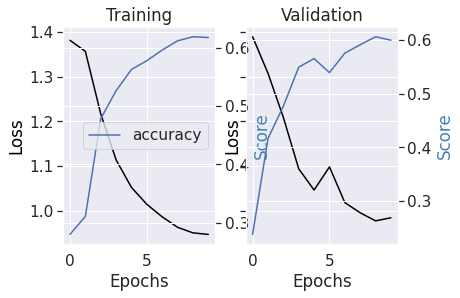

In [194]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(df_train['y']))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in df_train['y']])
## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [195]:
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

In [196]:
from sklearn.metrics import accuracy_score
y_true = df_test['y']
precision = precision_score(y_true, predicted, average=None)
recall_sc = recall_score(y_true, predicted, average=None)
f1_sc = f1_score(y_true, predicted, average=None)
df = pd.DataFrame(data=precision, index=class_names, columns=['Precision Score'])
df['Recall Score'] = recall_sc
df['F1 Score'] = f1_sc
print('Model Accuracy:', accuracy_score(y_true, predicted))
print(df)

Model Accuracy: 0.5736111111111111
           Precision Score  Recall Score  F1 Score
jealous           0.754386      0.469945  0.579125
joyful            0.534759      0.534759  0.534759
sad               0.523364      0.574359  0.547677
terrified         0.560976      0.741935  0.638889


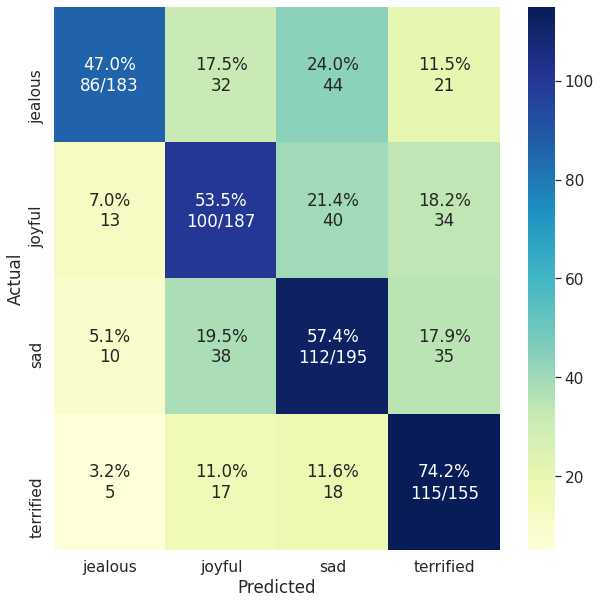

In [197]:
plot_cm(y_true, predicted)

In [ ]:
# 7
# 1. Fine tuning in this context refers to the use of additional supervised learning models to improve the performance of pre-trained word embeddings.  
# The Paper mentions pre-prending a predicted label to the utterance to inform generative models that predict the next utterance in a conversation sequence.
# 2. The transformer architecture is well suited to this application because the goal of a chatbot is to replicate human-like responses based on 
# vectorized inputs.
# 3. BLEU scores show the ability of a machine to translate or rephrase a sentence in a way that is mutually intelligible.
#     PPL or Perplexity is a way of evaluating a language models ability to predict a sample.
# 4. I think BLEU is the best metric because it equates with human's perceptions of quality or accuracy.  And humans are better at assessing empathy 
# in language.
# 5. More specific datasets and corpora related to empathetic speech.  Lots of supervised learning.
